In [2]:
import numpy as np
from utils import generate_sample, DEOptim, RandomOptim, PSOOptim, visualize_meshgrid, get_likelihood_grids, visualize_pred_meshgrid
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import t
import plotly.graph_objects as go


pso = PSOOptim(n_iters=100, n_particles=10, c1=0.5, c2=0.3, w=0.9, visualize=False)
optim = DEOptim(maxiter=100, visualize=False)

In [3]:
noise_scales = [1, 5, 10, 30, 50, 70]
target_func = lambda X: (20 + X**2 - 10 * np.cos(2*np.pi*X)).sum(axis=0)
n_train_data_points = 70
n_dims = 2
lower_bound = -2.5, -1.5
upper_bound = +1.5, +2.5


num_iter = 10
df_results = pd.DataFrame({ "noise scale":[], "Log Likelihood PSO":[], "Log Likelihood RS":[], "Log Likelihood DE":[]})
for noise in tqdm(noise_scales):
    for i in range(0,num_iter):
        X, y = generate_sample(70, n_dims, lower_bound, upper_bound, target_func, noise_scale=noise)

        rs = RandomOptim(maxiter=1000, visualize=False, random_state=i)

        X_train, y_train = generate_sample(n_train_data_points, n_dims, lower_bound, upper_bound, target_func, noise_scale=noise)
        # pso
        gpr_pso = GaussianProcessRegressor(optimizer=pso.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_pso.fit(X.T, y[...,None])

        # rs
        gpr_rs = GaussianProcessRegressor(optimizer=rs.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_rs.fit(X.T, y[...,None])

        # de
        gpr_de = GaussianProcessRegressor(optimizer=optim.optimize, kernel=RBF(length_scale=(1,1)))
        gpr_de.fit(X.T, y[...,None])

        df_results.loc[len(df_results)] = [noise, gpr_pso.log_marginal_likelihood_value_, gpr_rs.log_marginal_likelihood_value_, gpr_de.log_marginal_likelihood_value_]

print(df_results)

100%|██████████| 6/6 [02:51<00:00, 28.58s/it]

    noise scale  Log Likelihood PSO  Log Likelihood RS  Log Likelihood DE
0           1.0       -34611.311032      -43460.232650      -34611.012889
1           1.0       -34611.042757      -34837.489700      -34613.309092
2           1.0       -34613.713303      -37487.054003      -34611.012889
3           1.0       -34611.017452      -37802.859931      -34611.012889
4           1.0       -34611.030226      -42079.251748      -34611.012889
5           1.0       -34611.014350      -41935.578641      -34611.012889
6           1.0       -34611.014588      -41438.685549      -34611.012889
7           1.0       -34611.145871      -44238.592447      -34611.012889
8           1.0       -34611.056563      -44025.233522      -34611.012889
9           1.0       -34611.024600      -36346.711984      -34611.012889
10          5.0       -41573.161496      -51637.403311      -41573.155901
11          5.0       -41573.580761      -46456.792541      -41573.155901
12          5.0       -41573.172015   

In [4]:
df_results_ = df_results.groupby(['noise scale'], as_index=False).agg({'Log Likelihood PSO':['mean','std'], 'Log Likelihood RS':['mean','std'], 'Log Likelihood DE':['mean','std']})

df_results_["conf_95_o_pso"] = t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood PSO"]["std"] + df_results_["Log Likelihood PSO"]["mean"]
df_results_["conf_95_u_pso"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood PSO"]["std"] + df_results_["Log Likelihood PSO"]["mean"]

df_results_["conf_95_o_rs"] = t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood RS"]["std"] + df_results_["Log Likelihood RS"]["mean"]
df_results_["conf_95_u_rs"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood RS"]["std"] + df_results_["Log Likelihood RS"]["mean"]

df_results_["conf_95_o_de"] = t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood DE"]["std"] + df_results_["Log Likelihood DE"]["mean"]
df_results_["conf_95_u_de"] = -t.ppf((1+0.95)/2., 20-1) * df_results_["Log Likelihood DE"]["std"] + df_results_["Log Likelihood DE"]["mean"]

In [5]:
def rotate_func(x):
    return df_results_["Log Likelihood PSO"]["mean"] - x#-3_500 * x - 17_000

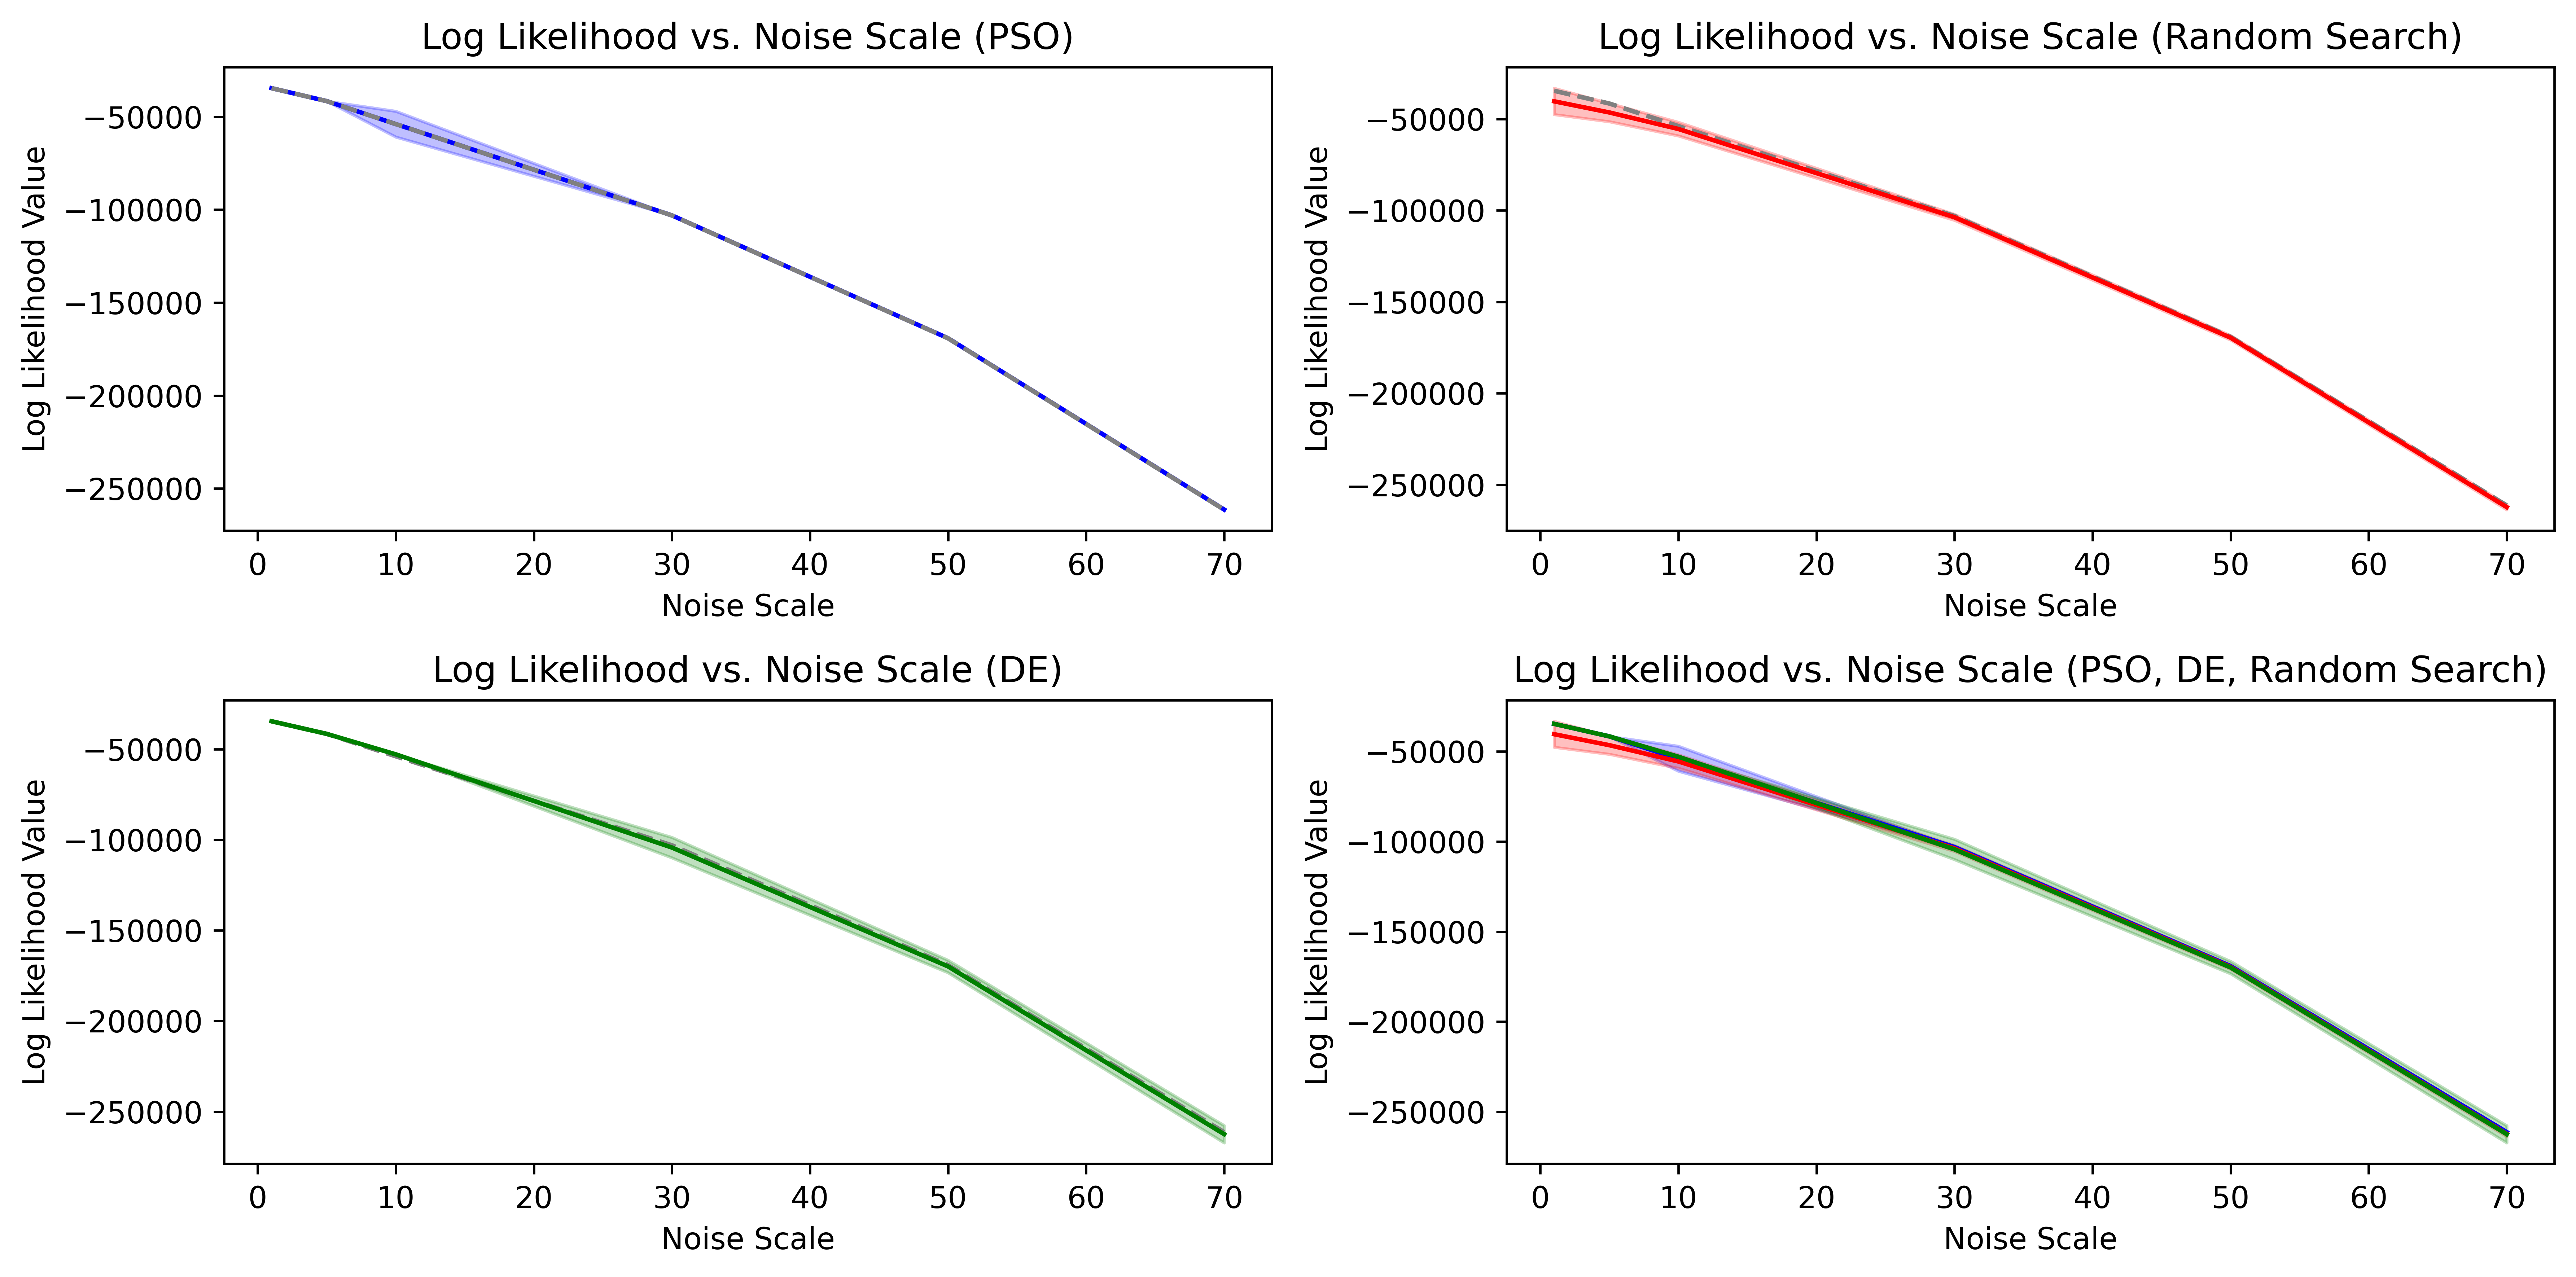

In [6]:
plt.figure(figsize=(12,6), dpi=600)
plt.subplot(221)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"], color="b")
# plot rotate_func with pointed lines
Xs = df_results_["noise scale"]
plt.plot(Xs, rotate_func(Xs), color="grey", linestyle="--")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"], df_results_["conf_95_o_pso"], color="b", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.title("Log Likelihood vs. Noise Scale (PSO)")
plt.subplot(222)
plt.plot(Xs, rotate_func(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"], color="r")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"], df_results_["conf_95_o_rs"], color="r", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.title("Log Likelihood vs. Noise Scale (Random Search)")
plt.tight_layout()

plt.subplot(223)
plt.plot(Xs, rotate_func(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"], color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"], df_results_["conf_95_o_de"], color="g", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.title("Log Likelihood vs. Noise Scale (DE)")
plt.subplot(224)
plt.plot(Xs, rotate_func(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"], color="b")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"], df_results_["conf_95_o_pso"], color="b", alpha=.25)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"], color="r")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"], df_results_["conf_95_o_rs"], color="r", alpha=.25)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"], color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"], df_results_["conf_95_o_de"], color="g", alpha=.25)
plt.title("Log Likelihood vs. Noise Scale (PSO, DE, Random Search)")
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.tight_layout()

In [7]:
df_results_

noise scale Log Likelihood PSO              Log Likelihood RS               \
                            mean          std              mean          std   
0         1.0      -34611.337074     0.840047     -40365.169017  3433.297950   
1         5.0      -41573.439119     0.632599     -46464.801158  2387.986580   
2        10.0      -53918.088036  3313.133712     -55497.469692  1783.553841   
3        30.0     -103021.392072     0.772283    -103744.197420   774.076026   
4        50.0     -169105.217041    63.966031    -169609.250575   579.508462   
5        70.0     -261265.028778     7.117074    -262224.212615   677.763140   

  Log Likelihood DE                conf_95_o_pso  conf_95_u_pso  \
               mean           std                                 
0     -34611.242509  7.261231e-01  -34609.578836  -34613.095313   
1     -41573.155901  5.437734e-09  -41572.115074  -41574.763164   
2     -52869.682825  2.496224e-01  -46983.619482  -60852.556590   
3    -104283.597378  2.694654e+03 -103019.775665 -103023.008479   
4    -169874.614902  1.643397e+03 -168971.334599 -169239.099483   
5    -262418.563612  2.279577e+03 -261250.132571 -261279.924986   

    conf_95_o_rs   conf_95_u_rs   conf_95_o_de   conf_95_u_de  
                                                               
0  -33179.193822  -47551.144213  -34609.722716  -34612.762302  
1  -41466.687804  -51462.914512  -41573.155901  -41573.155901  
2  -51764.448600  -59230.490784  -52869.160359  -52870.205290  
3 -102124.037678 -105364.357161  -98643.622089 -109923.572667  
4 -168396.325425 -170822.175725 -166434.946341 -173314.283462  
5 -260805.638060 -263642.787169 -257647.353536 -267189.773687

In [8]:
# liebe ai bitte helfe mir: kannst du die jeweiligen dataframe spalten in ein array umwandeln? DANKE
Xs = df_results_["noise scale"].to_numpy()
Ys = {
    "PSO": df_results_["Log Likelihood PSO"]["mean"].to_numpy(),
    "RS": df_results_["Log Likelihood RS"]["mean"].to_numpy(),
    "DE": df_results_["Log Likelihood DE"]["mean"].to_numpy()
}
confidence_intervalls = {
    "PSO": (df_results_["conf_95_o_pso"].to_numpy(), df_results_["conf_95_u_pso"].to_numpy()),
    "RS": (df_results_["conf_95_o_rs"].to_numpy(), df_results_["conf_95_u_rs"].to_numpy()),
    "DE": (df_results_["conf_95_o_de"].to_numpy(), df_results_["conf_95_u_de"].to_numpy())
}

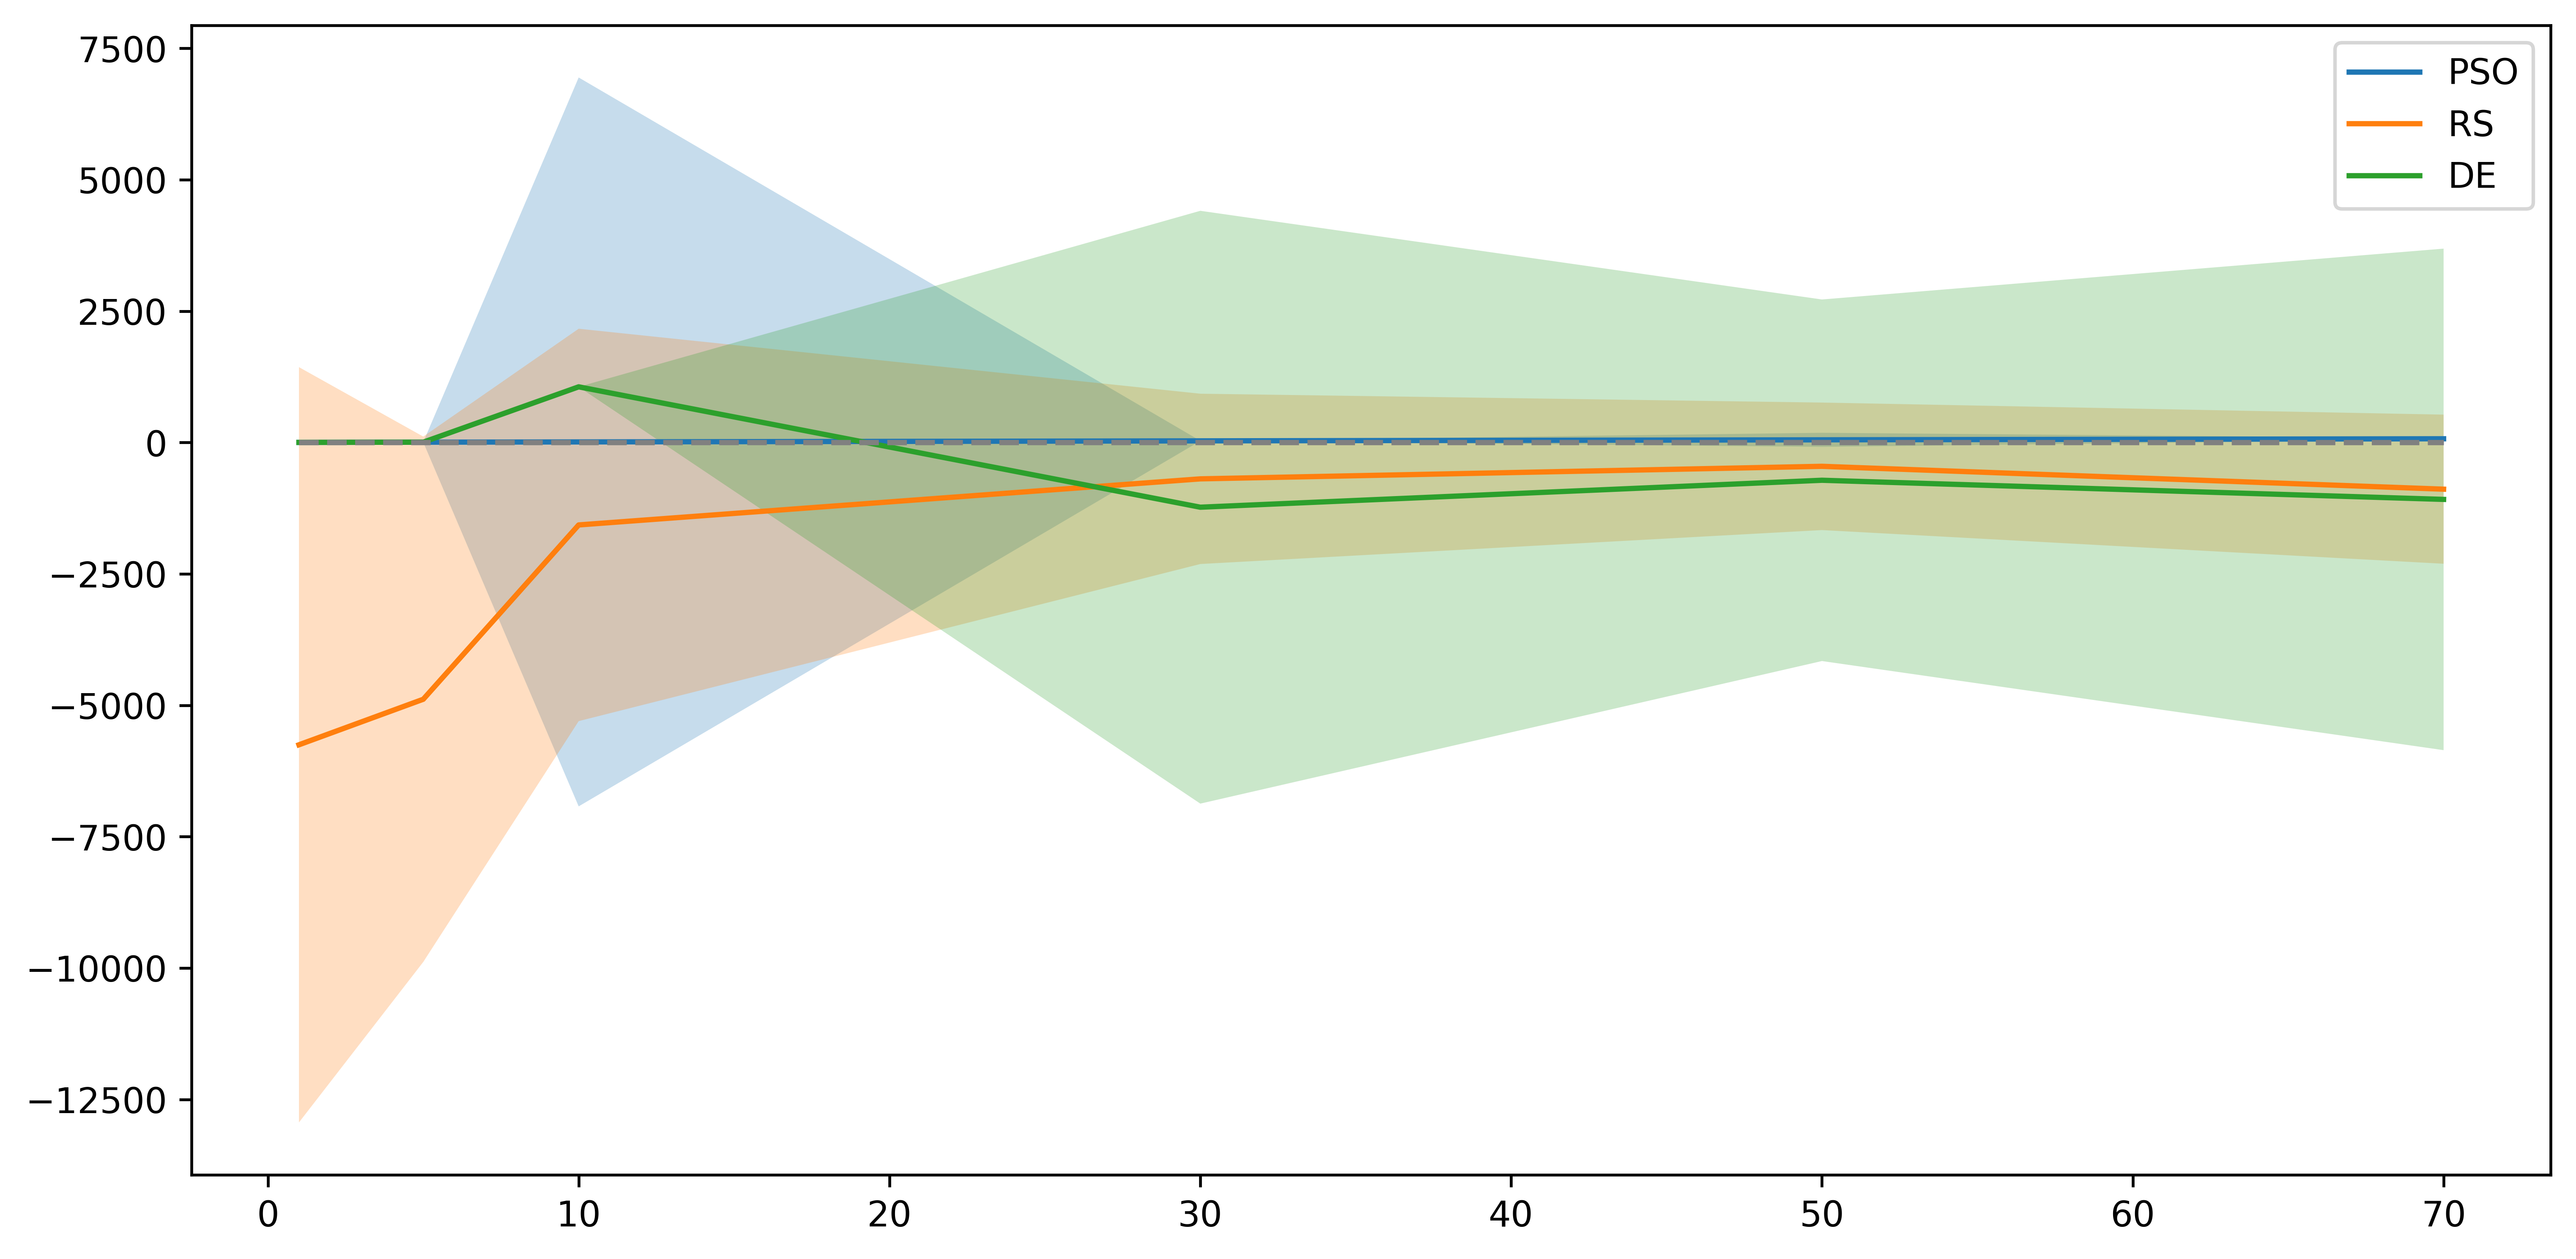

In [9]:
plt.figure(figsize=(12,6), dpi=600)
for y in Ys: # for each y-value
    plt.plot(Xs, Ys[y]-rotate_func(Xs), label=y)
    plt.fill_between(Xs, confidence_intervalls[y][0]-rotate_func(Xs), confidence_intervalls[y][1]-rotate_func(Xs), alpha=.25)

plt.plot(Xs, np.zeros(len(Xs)), color="grey", linestyle="--")
plt.legend();

Text(0.5, 1.0, 'Log Likelihood vs. Noise Scale (DE)')

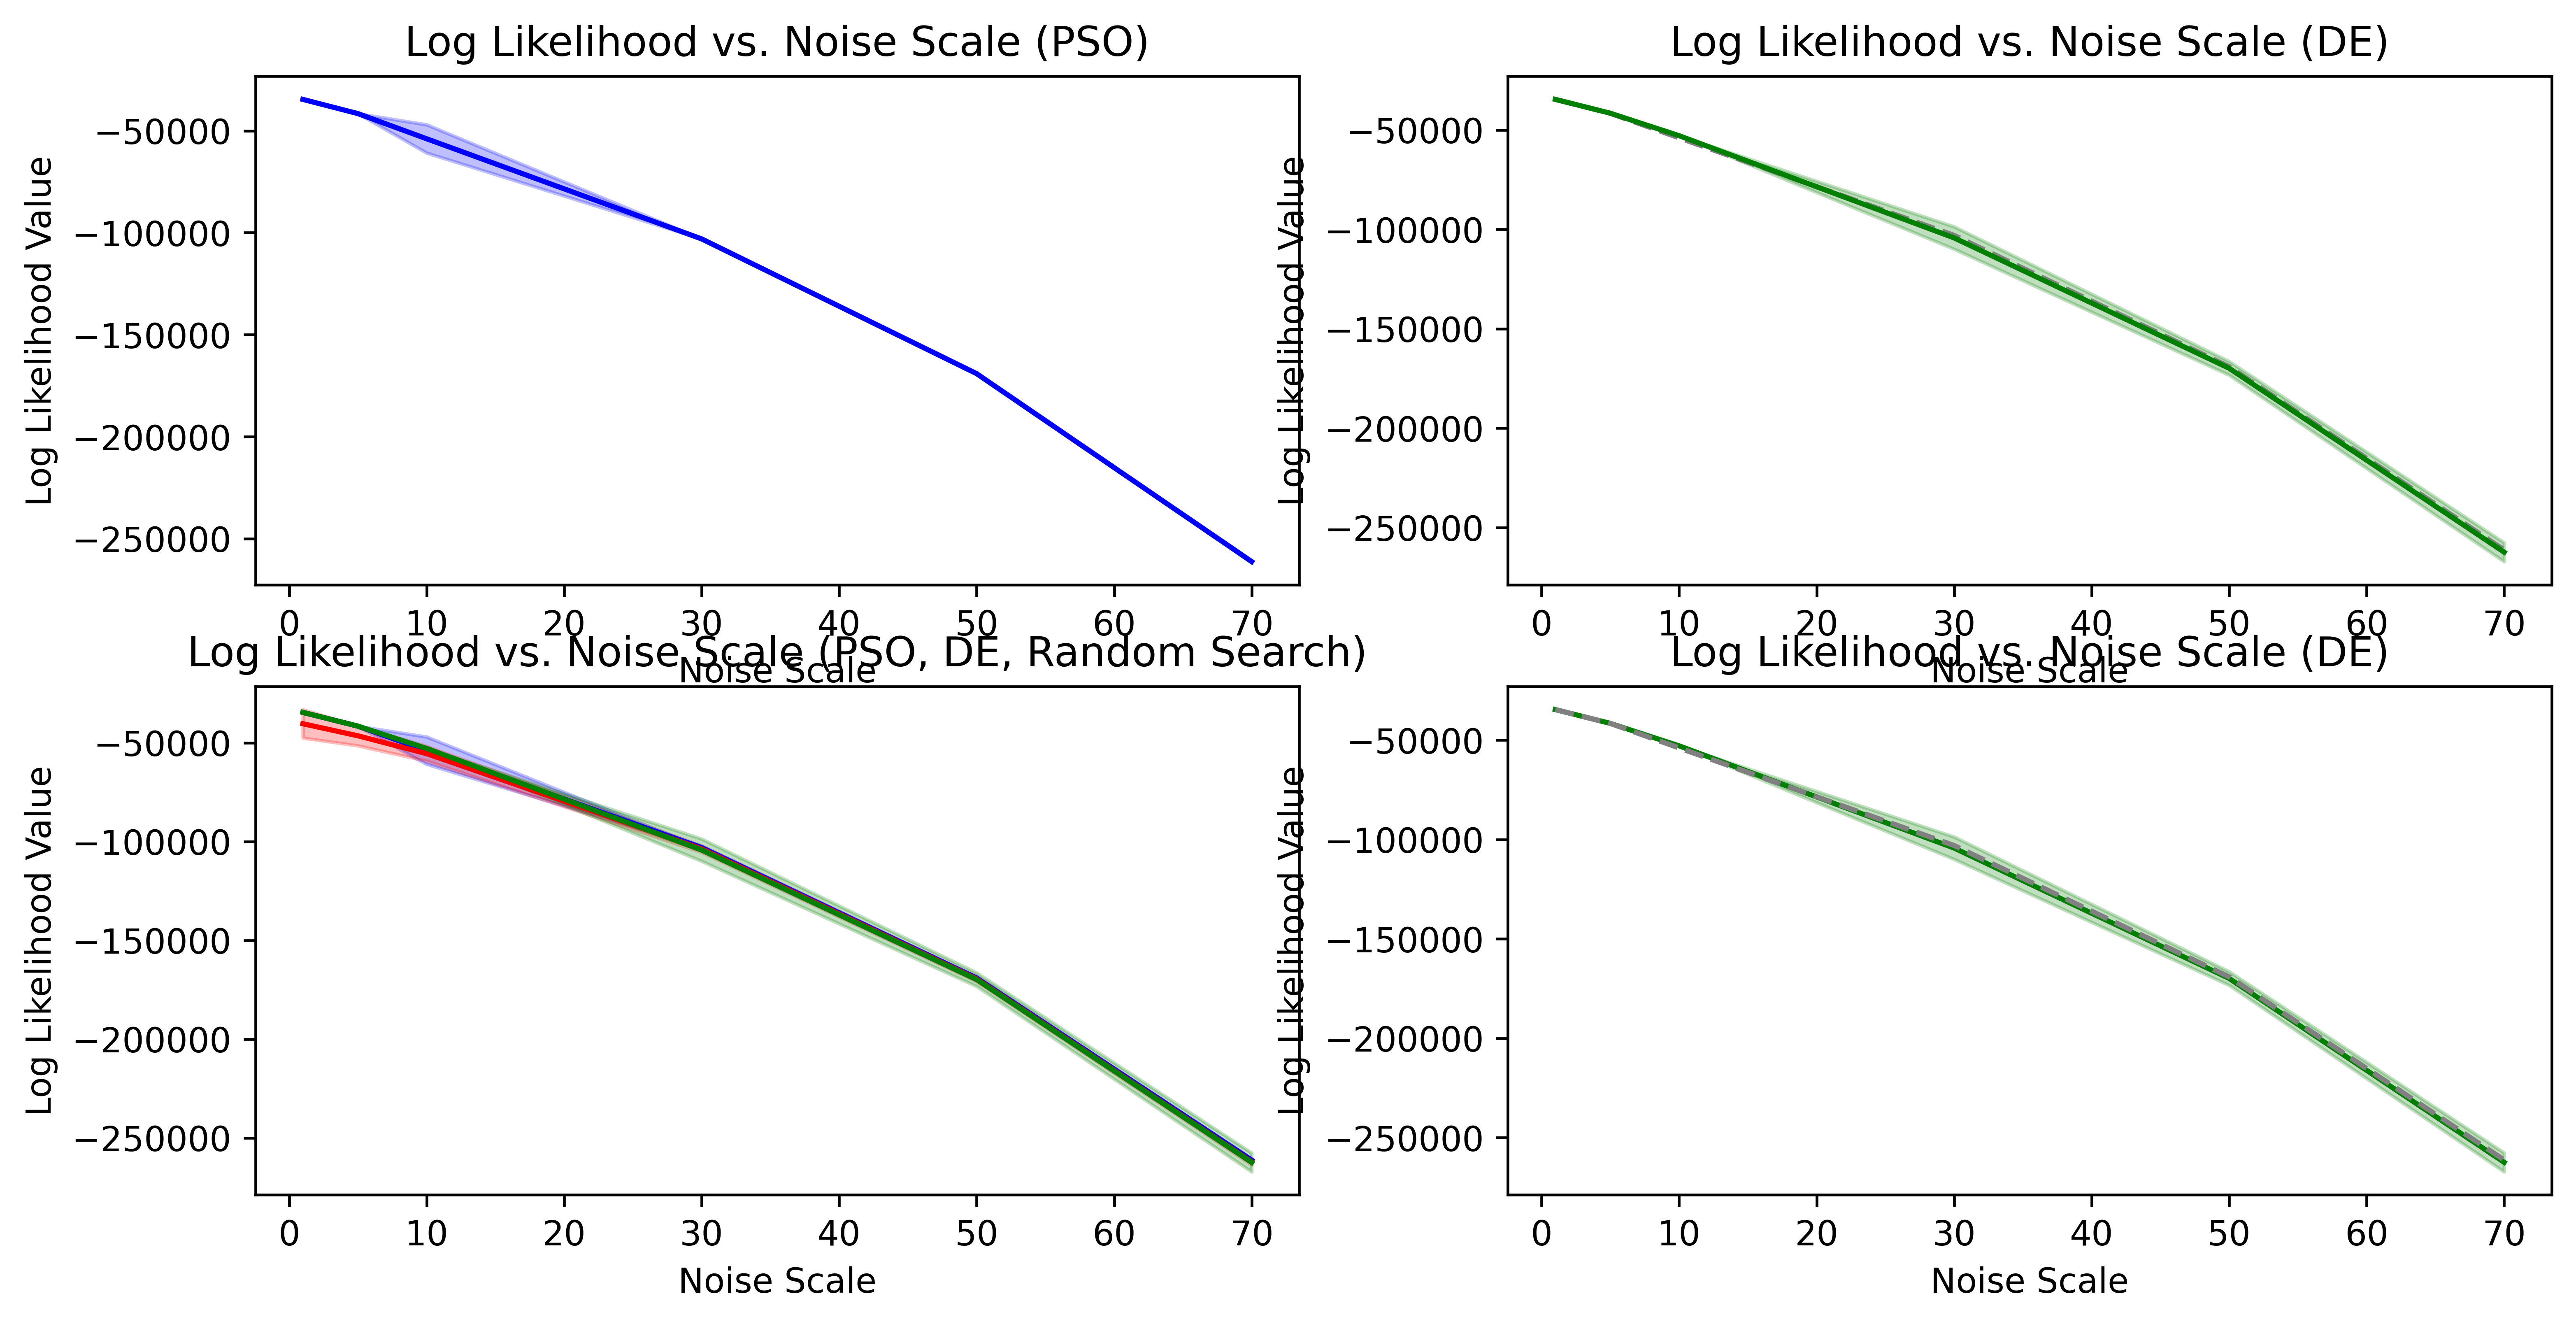

In [14]:
plt.figure(figsize=(12,6), dpi=600)

plt.subplot(221)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"], color="b")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"], df_results_["conf_95_o_pso"], color="b", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")

plt.title("Log Likelihood vs. Noise Scale (PSO)")
plt.subplot(222)
plt.plot(Xs, rotate_func(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"], color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"], df_results_["conf_95_o_de"], color="g", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")

plt.title("Log Likelihood vs. Noise Scale (DE)")
plt.subplot(223)
plt.plot(Xs, rotate_func(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"], color="b")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"], df_results_["conf_95_o_pso"], color="b", alpha=.25)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"], color="r")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"], df_results_["conf_95_o_rs"], color="r", alpha=.25)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"], color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"], df_results_["conf_95_o_de"], color="g", alpha=.25)
plt.title("Log Likelihood vs. Noise Scale (PSO, DE, Random Search)")
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")

plt.subplot(224)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"], color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"], df_results_["conf_95_o_de"], color="g", alpha=.25)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"], color="grey", linestyle="--")
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.title("Log Likelihood vs. Noise Scale (DE)")

# plt.subplot(224)
# plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"], color="b")
# plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"], df_results_["conf_95_o_pso"], color="b", alpha=.25)
# plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"], color="r")
# plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"], df_results_["conf_95_o_rs"], color="r", alpha=.25)
# plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"], color="g")
# plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"], df_results_["conf_95_o_de"], color="g", alpha=.25)
# plt.title("Log Likelihood vs. Noise Scale (PSO, DE, Random Search)")
# plt.xlabel("Noise Scale")
# plt.ylabel("Log Likelihood Value")
# plt.tight_layout()

In [11]:
rotation = rotate_func(df_results_["noise scale"])

TypeError: 'other' must be an instance of matplotlib.axes._base._AxesBase, not a matplotlib.lines.Line2D

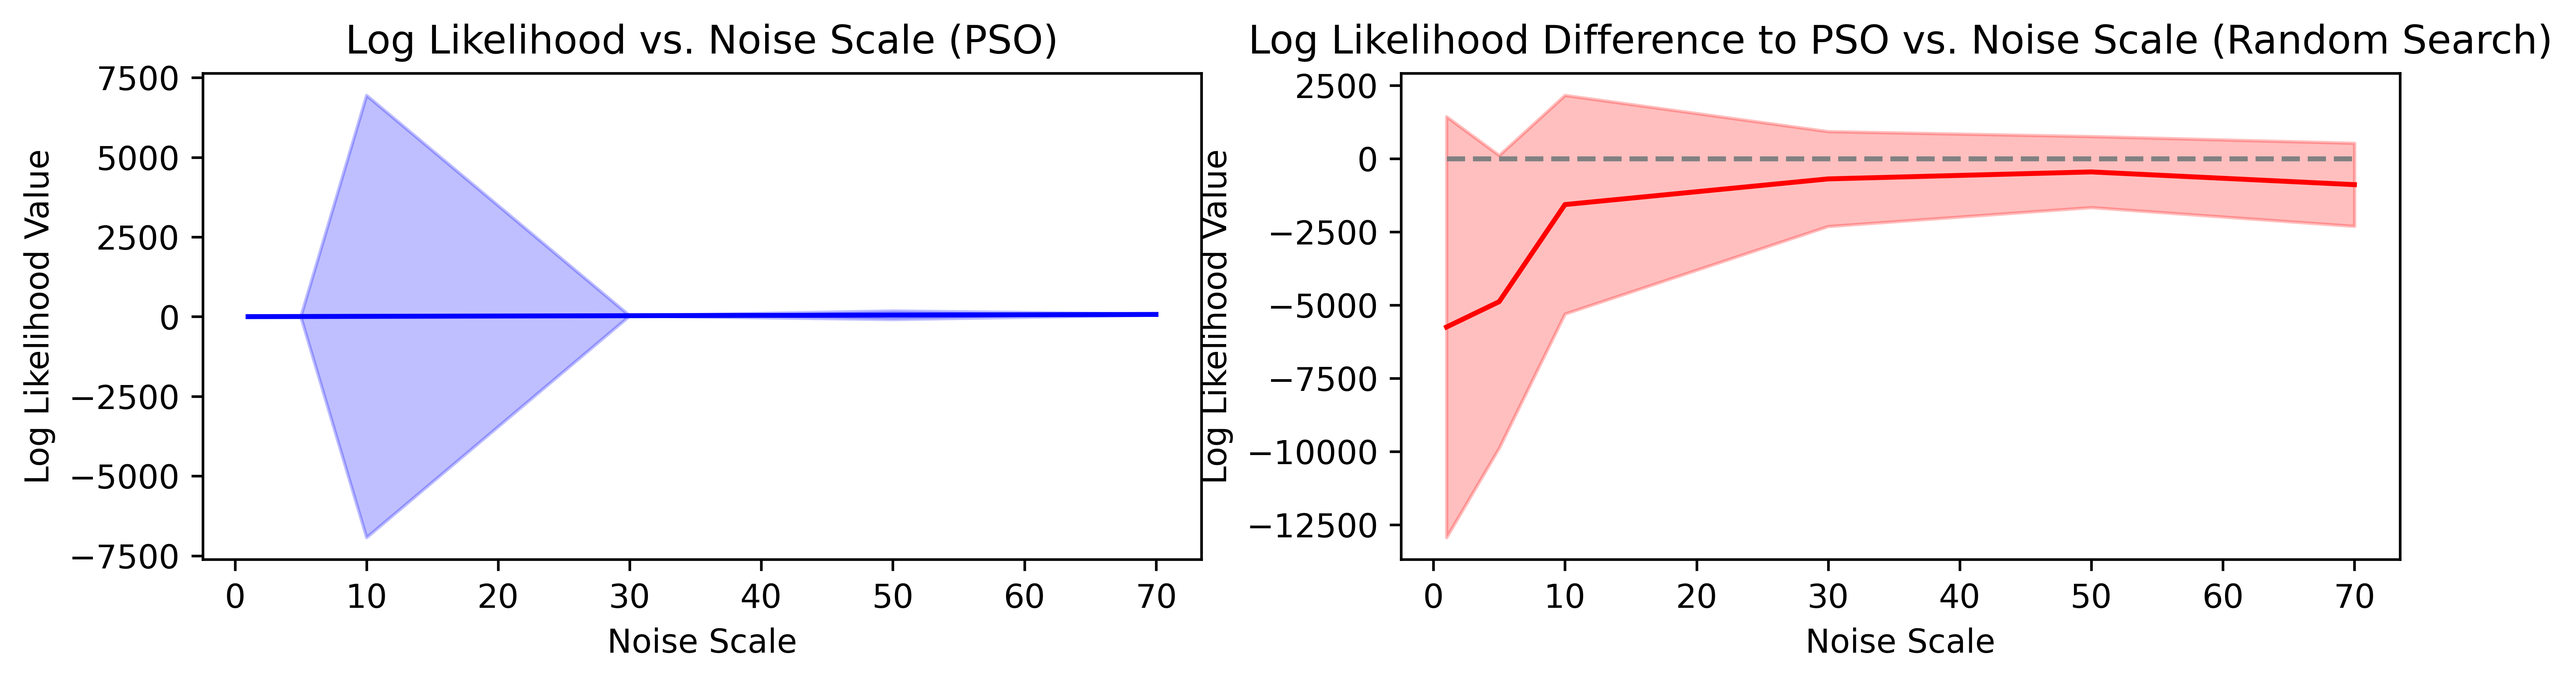

In [20]:
plt.figure(figsize=(12,6), dpi=600)
plt.subplot(221)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"]-rotation, color="b")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"]-rotation, df_results_["conf_95_o_pso"]-rotation, color="b", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")

plt.title("Log Likelihood vs. Noise Scale (PSO)")
plt.subplot(222)
plt.plot(Xs, np.zeros_like(Xs), color="grey", linestyle="--")
ax = plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"]-rotation, color="r")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"]-rotation, df_results_["conf_95_o_rs"]-rotation, color="r", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")


plt.title("Log Likelihood Difference to PSO vs. Noise Scale (Random Search)")
plt.subplot(223, sharey=ax[0])
plt.plot(Xs, np.zeros_like(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"]-rotation, color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"]-rotation, df_results_["conf_95_o_de"]-rotation, color="g", alpha=.25)
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")

plt.title("Log Likelihood vs. Noise Scale (DE)")
plt.subplot(224, sharey=ax[0])
plt.plot(Xs, np.zeros_like(Xs), color="grey", linestyle="--")
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood PSO"]["mean"]-rotation, color="b")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_pso"]-rotation, df_results_["conf_95_o_pso"]-rotation, color="b", alpha=.25)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood RS"]["mean"]-rotation, color="r")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_rs"]-rotation, df_results_["conf_95_o_rs"]-rotation, color="r", alpha=.25)
plt.plot(df_results_["noise scale"], df_results_["Log Likelihood DE"]["mean"]-rotation, color="g")
plt.fill_between(df_results_["noise scale"], df_results_["conf_95_u_de"]-rotation, df_results_["conf_95_o_de"]-rotation, color="g", alpha=.25)

plt.title("Log Likelihood vs. Noise Scale (PSO, DE, Random Search)")
plt.xlabel("Noise Scale")
plt.ylabel("Log Likelihood Value")
plt.tight_layout()


In [19]:
ax